In [9]:
# Set threading parameters before importing TensorFlow
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import mixed_precision
import keras_tuner as kt
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate, Multiply, Permute, Lambda, Reshape, Activation, Dropout, Add, GlobalMaxPooling1D, GlobalAvgPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
# Directory containing the CSV files
csv_directory = "D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data"

## Load the data

In [11]:
# Load the current and vibration data
current_files = [file for file in os.listdir(csv_directory) if 'current' in file]
vibration_files = [file for file in os.listdir(csv_directory) if 'vibration' in file]

current_dfs = [pd.read_csv(os.path.join(csv_directory, file)) for file in current_files]
vibration_dfs = [pd.read_csv(os.path.join(csv_directory, file)) for file in vibration_files]

# Combine all current data and vibration data into single DataFrames
current_data = pd.concat(current_dfs, ignore_index=True)
vibration_data = pd.concat(vibration_dfs, ignore_index=True)

# Ensure your data is in the float32 format
def convert_to_float32(data):
    return data.astype(np.float32)

current_data = convert_to_float32(current_data)
vibration_data = convert_to_float32(vibration_data)

## Data preprocessing
### Outliers removal

Raw current_data shape: (2100007, 7)
Raw vibration_data shape: (2100007, 2)
Raw current_data head:
      Time   RotorSpeed  V_ab  I_a  I_b  I_c  OutputTorque
0  0.0000  7500.000000   0.0  0.0  0.0  0.0      0.000000
1  0.0005  7496.208984   0.0  0.0  0.0  0.0      0.000140
2  0.0010  7492.422363   0.0  0.0  0.0  0.0      0.000020
3  0.0015  7488.639160   0.0  0.0  0.0  0.0      0.000224
4  0.0020  7484.859863   0.0  0.0  0.0  0.0      0.000083
Raw vibration_data head:
      Time  RotorVibration
0  0.0000       -0.000008
1  0.0005       -0.000008
2  0.0010       -0.000340
3  0.0015        0.002847
4  0.0020        0.001061


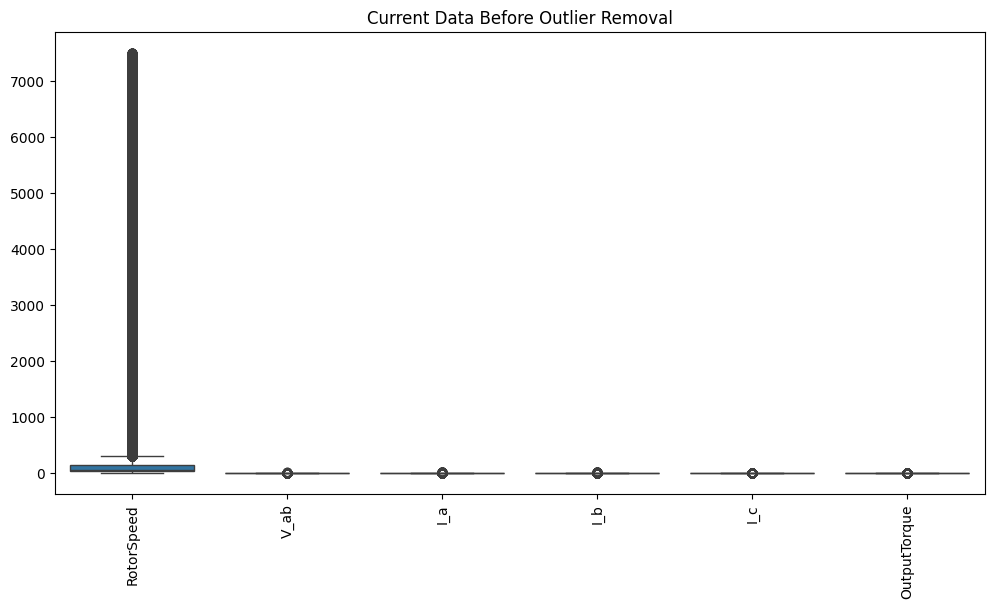

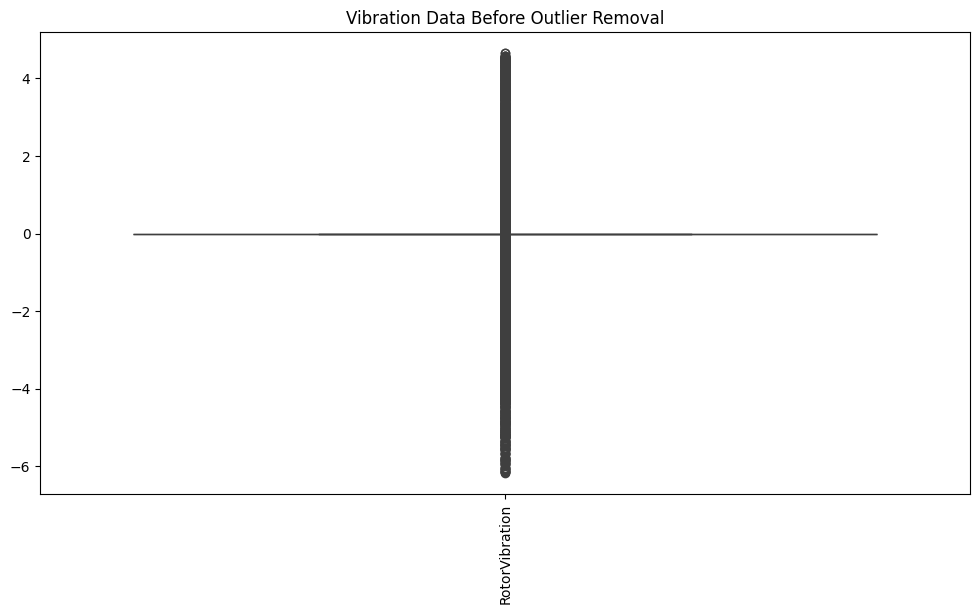

no outliers current_data shape: (1043780, 6)
no outliers vibration_data shape: (1269865, 1)
no outliers current_data head:
        RotorSpeed      V_ab       I_a       I_b       I_c  OutputTorque
43768  291.405487  0.046947  0.056818  0.058820  0.057623      0.000044
43776  291.348480  0.030672  0.053324  0.056534  0.052024      0.000030
43780  291.320007  0.041212  0.057223  0.056343  0.057165      0.000016
43797  291.199036  0.028753  0.055587  0.056652  0.055472      0.000018
43804  291.149261  0.020664  0.060254  0.057087  0.056395     -0.000029
no outliers vibration_data head:
     RotorVibration
0        -0.000008
1        -0.000008
2        -0.000340
10       -0.000608
13       -0.000383


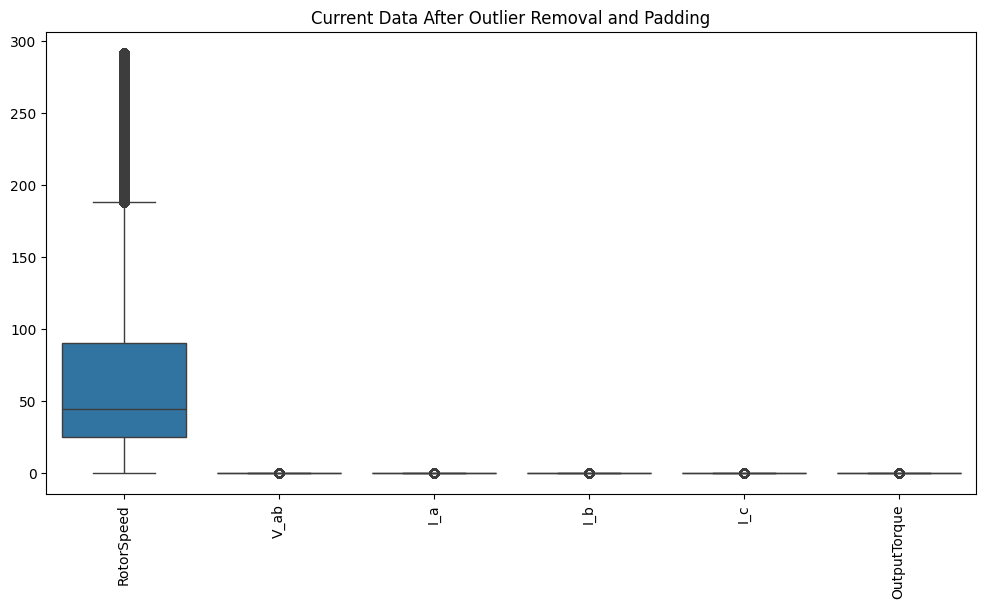

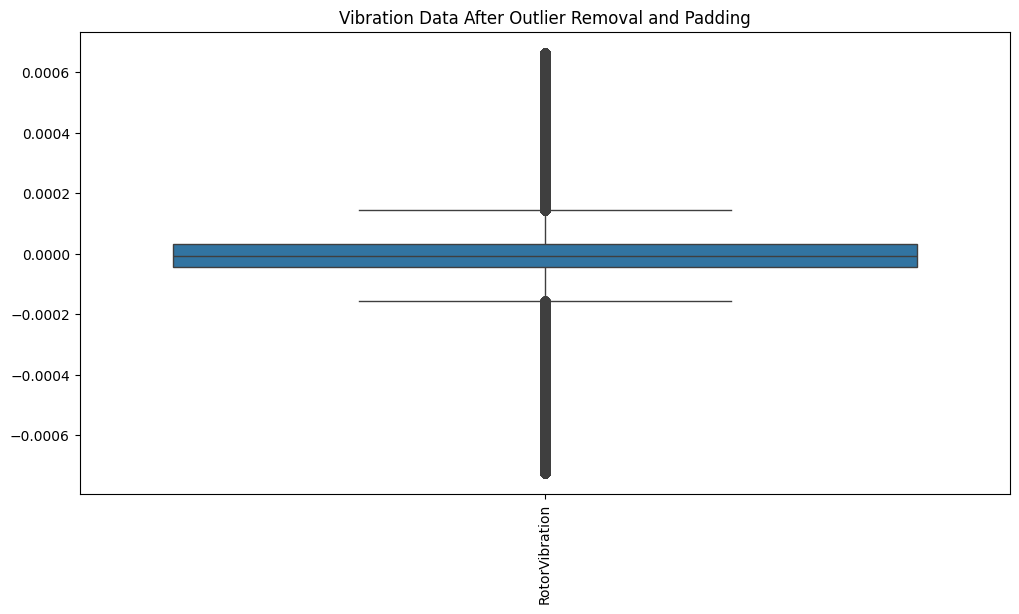

after Padding current_data shape: (1269865, 7)
after Padding vibration_data shape: (1269865, 2)
after Padding current_data head:
      Time  RotorSpeed      V_ab       I_a       I_b       I_c  OutputTorque
0  0.0000  291.405487  0.046947  0.056818  0.058820  0.057623      0.000044
1  0.0005  291.348480  0.030672  0.053324  0.056534  0.052024      0.000030
2  0.0010  291.320007  0.041212  0.057223  0.056343  0.057165      0.000016
3  0.0015  291.199036  0.028753  0.055587  0.056652  0.055472      0.000018
4  0.0020  291.149261  0.020664  0.060254  0.057087  0.056395     -0.000029
after Padding vibration_data head:
      Time  RotorVibration
0  0.0000       -0.000008
1  0.0005       -0.000008
2  0.0010       -0.000340
3  0.0015       -0.000608
4  0.0020       -0.000383


In [12]:
# Ensure there are no missing values
current_data = current_data.dropna()
vibration_data = vibration_data.dropna()

# Ensure data is numeric
current_data = current_data.apply(pd.to_numeric)
vibration_data = vibration_data.apply(pd.to_numeric)

# Print shapes and first few rows of raw data for debugging
print("Raw current_data shape:", current_data.shape)
print("Raw vibration_data shape:", vibration_data.shape)
print("Raw current_data head:\n", current_data.head())
print("Raw vibration_data head:\n", vibration_data.head())

# Visualize data using box plots
def visualize_data(data, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Visualize data before outlier removal
visualize_data(current_data.iloc[:, 1:], "Current Data Before Outlier Removal")
visualize_data(vibration_data.iloc[:, 1:], "Vibration Data Before Outlier Removal")

# Remove outliers using IQR method
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    data_no_outliers = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data_no_outliers

# Remove outliers
current_data_no_outliers = remove_outliers_iqr(current_data.iloc[:, 1:])
vibration_data_no_outliers = remove_outliers_iqr(vibration_data.iloc[:, 1:])

# Print shapes and first few rows of no outliers data for debugging
print("no outliers current_data shape:", current_data_no_outliers.shape)
print("no outliers vibration_data shape:", vibration_data_no_outliers.shape)
print("no outliers current_data head:\n", current_data_no_outliers.head())
print("no outliers vibration_data head:\n", vibration_data_no_outliers.head())

# Determine the maximum length for padding
max_length = max(len(current_data_no_outliers), len(vibration_data_no_outliers))

# Padding function
def pad_data(data, target_length):
    current_length = len(data)
    if current_length < target_length:
        padding_length = target_length - current_length
        padding = np.zeros((padding_length, data.shape[1]))
        data_padded = np.vstack((data, padding))
        return data_padded
    return data

# Pad the datasets to the same length
current_data_no_outliers_padded = pad_data(current_data_no_outliers.values, max_length)
vibration_data_no_outliers_padded = pad_data(vibration_data_no_outliers.values, max_length)

# Re-add the 'Time' column after removing outliers
current_data_no_outliers_padded = pd.DataFrame(current_data_no_outliers_padded, columns=current_data.columns[1:])
current_data_no_outliers_padded.insert(0, 'Time', current_data['Time'][:max_length].values)

vibration_data_no_outliers_padded = pd.DataFrame(vibration_data_no_outliers_padded, columns=vibration_data.columns[1:])
vibration_data_no_outliers_padded.insert(0, 'Time', vibration_data['Time'][:max_length].values)

# Visualize data after outlier removal
visualize_data(current_data_no_outliers_padded.iloc[:, 1:], "Current Data After Outlier Removal and Padding")
visualize_data(vibration_data_no_outliers_padded.iloc[:, 1:], "Vibration Data After Outlier Removal and Padding")

# Print shapes and first few rows of no outliers data for debugging
print("after Padding current_data shape:", current_data_no_outliers_padded.shape)
print("after Padding vibration_data shape:", vibration_data_no_outliers_padded.shape)
print("after Padding current_data head:\n", current_data_no_outliers_padded.head())
print("after Padding vibration_data head:\n", vibration_data_no_outliers_padded.head())

### Data normalization

In [13]:
# Print shapes and first few rows of no outliers data for debugging
print("after Padding current_data shape:", current_data_no_outliers_padded.shape)
print("after Padding vibration_data shape:", vibration_data_no_outliers_padded.shape)
print("after Padding current_data head:\n", current_data_no_outliers_padded.head())
print("after Padding vibration_data head:\n", vibration_data_no_outliers_padded.head())

# Normalize the Data
current_scaler = StandardScaler().fit(current_data_no_outliers_padded.iloc[:, 1:])
vibration_scaler = StandardScaler().fit(vibration_data_no_outliers_padded.iloc[:, 1:])

current_data_normalized_values = current_scaler.transform(current_data_no_outliers_padded.iloc[:, 1:])
vibration_data_normalized_values = vibration_scaler.transform(vibration_data_no_outliers_padded.iloc[:, 1:])

# Add the 'Time' column back to the normalized data
current_data_normalized = pd.DataFrame(current_data_normalized_values, columns=current_data_no_outliers_padded.columns[1:])
current_data_normalized.insert(0, 'Time', current_data_no_outliers_padded['Time'])

vibration_data_normalized = pd.DataFrame(vibration_data_normalized_values, columns=vibration_data_no_outliers_padded.columns[1:])
vibration_data_normalized.insert(0, 'Time', vibration_data_no_outliers_padded['Time'])

# Print shapes and first few rows of normalized data for debugging
print("Normalized current_data shape:", current_data_normalized.shape)
print("Normalized vibration_data shape:", vibration_data_normalized.shape)
print("Normalized current_data head:\n", current_data_normalized.head())
print("Normalized vibration_data head:\n", vibration_data_normalized.head())

# Check the range of normalized values
print("Range of normalized current_data values:", current_data_normalized.iloc[:, 1:].min().min(), "to", current_data_normalized.iloc[:, 1:].max().max())
print("Range of normalized vibration_data values:", vibration_data_normalized.iloc[:, 1:].min().min(), "to", vibration_data_normalized.iloc[:, 1:].max().max())

after Padding current_data shape: (1269865, 7)
after Padding vibration_data shape: (1269865, 2)
after Padding current_data head:
      Time  RotorSpeed      V_ab       I_a       I_b       I_c  OutputTorque
0  0.0000  291.405487  0.046947  0.056818  0.058820  0.057623      0.000044
1  0.0005  291.348480  0.030672  0.053324  0.056534  0.052024      0.000030
2  0.0010  291.320007  0.041212  0.057223  0.056343  0.057165      0.000016
3  0.0015  291.199036  0.028753  0.055587  0.056652  0.055472      0.000018
4  0.0020  291.149261  0.020664  0.060254  0.057087  0.056395     -0.000029
after Padding vibration_data head:
      Time  RotorVibration
0  0.0000       -0.000008
1  0.0005       -0.000008
2  0.0010       -0.000340
3  0.0015       -0.000608
4  0.0020       -0.000383
Normalized current_data shape: (1269865, 7)
Normalized vibration_data shape: (1269865, 2)
Normalized current_data head:
      Time  RotorSpeed      V_ab       I_a       I_b       I_c  OutputTorque
0  0.0000    3.511841  1.

In [14]:
# Function to create sequences without shuffling
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 100

# Create sequences for current and vibration data (excluding the 'Time' column)
current_sequences = create_sequences(current_data_normalized.iloc[:, 1:], sequence_length)
vibration_sequences = create_sequences(vibration_data_normalized.iloc[:, 1:], sequence_length)

# Assume the RUL is the last value in the Time column for each sequence
rul = current_data_normalized['Time'][sequence_length:].values

# Split the sequences into training and validation sets while maintaining the order
split_index = int(len(current_sequences) * 0.8)
train_current_seq = current_sequences[:split_index]
val_current_seq = current_sequences[split_index:]
train_vibration_seq = vibration_sequences[:split_index]
val_vibration_seq = vibration_sequences[split_index:]
train_rul = rul[:split_index]
val_rul = rul[split_index:split_index + len(val_current_seq)]

# Print the shapes and types of sequences for debugging
print("train_current_seq shape:", train_current_seq.shape, "dtype:", train_current_seq.dtype)
print("train_vibration_seq shape:", train_vibration_seq.shape, "dtype:", train_vibration_seq.dtype)
print("train_rul shape:", train_rul.shape, "dtype:", train_rul.dtype)
print("val_current_seq shape:", val_current_seq.shape, "dtype:", val_current_seq.dtype)
print("val_vibration_seq shape:", val_vibration_seq.shape, "dtype:", val_vibration_seq.dtype)
print("val_rul shape:", val_rul.shape, "dtype:", val_rul.dtype)

# Print the first few rows of the sequences
print("First few rows of train_rul:\n", train_rul[:2])
print("First few rows of val_rul:\n", val_rul[:2])

# Create a data generator
def data_generator(current_seq, vibration_seq, rul):
    for i in range(len(current_seq)):
        yield (current_seq[i], vibration_seq[i]), rul[i]

batch_size = 16

# Use tf.data.Dataset.from_generator to create datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_current_seq, train_vibration_seq, train_rul),
    output_signature=(
        (tf.TensorSpec(shape=(100, 6), dtype=tf.float32),
         tf.TensorSpec(shape=(100, 1), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(batch_size).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_current_seq, val_vibration_seq, val_rul),
    output_signature=(
        (tf.TensorSpec(shape=(100, 6), dtype=tf.float32),
         tf.TensorSpec(shape=(100, 1), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(batch_size).repeat()

# Check dataset shapes and types
for data, label in train_dataset.take(1):
    print("Batch data shapes:", [d.shape for d in data], "Batch label shape:", label.shape)
    print("Batch data types:", [d.dtype for d in data], "Batch label dtype:", label.dtype)

for data, label in val_dataset.take(1):
    print("Batch data shapes:", [d.shape for d in data], "Batch label shape:", label.shape)
    print("Batch data types:", [d.dtype for d in data], "Batch label dtype:", label.dtype)

train_current_seq shape: (1015812, 100, 6) dtype: float64
train_vibration_seq shape: (1015812, 100, 1) dtype: float32
train_rul shape: (1015812,) dtype: float32
val_current_seq shape: (253953, 100, 6) dtype: float64
val_vibration_seq shape: (253953, 100, 1) dtype: float32
val_rul shape: (253953,) dtype: float32
First few rows of train_rul:
 [0.05   0.0505]
First few rows of val_rul:
 [57.954 57.955]
Batch data shapes: [TensorShape([16, 100, 6]), TensorShape([16, 100, 1])] Batch label shape: (16,)
Batch data types: [tf.float32, tf.float32] Batch label dtype: <dtype: 'float32'>
Batch data shapes: [TensorShape([16, 100, 6]), TensorShape([16, 100, 1])] Batch label shape: (16,)
Batch data types: [tf.float32, tf.float32] Batch label dtype: <dtype: 'float32'>


In [15]:
# Define custom layers for time and channel attention
class TimeAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(TimeAttentionLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W_h = tf.keras.layers.Dense(hidden_size)
        self.W_t = tf.keras.layers.Dense(hidden_size)
        self.v = tf.keras.layers.Dense(1)

    def call(self, inputs):
        h_t = inputs
        u_t = tf.nn.tanh(self.W_h(h_t) + tf.expand_dims(self.W_t(h_t[:, -1, :]), axis=1))
        a_t = tf.nn.softmax(self.v(u_t), axis=1)
        S_t = tf.reduce_sum(a_t * h_t, axis=1)
        return S_t

    def get_config(self):
        config = super(TimeAttentionLayer, self).get_config()
        config.update({"hidden_size": self.hidden_size})
        return config

class ChannelAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.num_channels = num_channels
        self.W_v = tf.keras.layers.Dense(num_channels)
        self.W_m = tf.keras.layers.Dense(num_channels)
        self.W_n = tf.keras.layers.Dense(num_channels)
        # Adjust the output dimension of W_a to 1 for a single attention weight
        self.W_a = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        H = inputs
        v_j = GlobalAvgPool1D()(H)
        m_j = GlobalMaxPooling1D()(H)
        n_j = tf.reduce_sum(H, axis=1)
        concatenated = tf.concat([v_j, m_j, n_j], axis=1)
        r = tf.nn.relu(self.W_v(concatenated) + self.W_m(concatenated) + self.W_n(concatenated))
        # Calculate a single attention weight for the entire time series
        attention_weight = self.W_a(r)
        # Apply attention weight to the input H
        attention_output = attention_weight * H
        return attention_output # Output maintains the shape of H

    def get_config(self):
        config = super(ChannelAttentionLayer, self).get_config()
        config.update({"num_channels": self.num_channels})
        return config

# Define a custom layer for expand_dims
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)
    
    def get_config(self):
        config = super(ExpandDimsLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

class SqueezeLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        # Handle the batch dimension
        if inputs.shape[self.axis] == 1:
            return tf.squeeze(inputs, axis=self.axis)
        else:
            return inputs  # Return the input as is if the dimension is not 1
        
    def get_config(self):
        config = super(SqueezeLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

    def compute_output_shape(self, input_shape):
        # Handle the case where the axis is squeezed
        if input_shape[self.axis] == 1:
            output_shape = list(input_shape)
            del output_shape[self.axis]
            return tuple(output_shape)
        else:
            return input_shape  # Return the original shape if not squeezing

In [16]:
# input shape for stator and rotor data
stator_input_shape = (100, 6) # (sequence_length, number of stator features)
rotor_input_shape = (100, 1) # (sequence_length, number of rotor features)

# Define the model with modified channel attention mechanism and dropout
def build_model(hp):
    hidden_size = hp.Int('hidden_size', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.2)
    dense_size = hp.Int('dense_size', min_value=32, max_value=128, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')

    # Stator current input
    input_stator = Input(shape=(100, 6), name='stator_input')
    lstm_stator = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_stator)
    time_attention_stator = TimeAttentionLayer(hidden_size)(lstm_stator)

    # Rotor vibration input
    input_rotor = Input(shape=(100, 1), name='rotor_input')
    lstm_rotor = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_rotor)
    time_attention_rotor = TimeAttentionLayer(hidden_size)(lstm_rotor)

    # Concatenate and Dense layers with Dropout
    concatenated = Concatenate()([time_attention_stator, time_attention_rotor])
    expanded = ExpandDimsLayer(axis=1)(concatenated)
    channel_attention_layer = ChannelAttentionLayer(hidden_size * 2)(expanded)
    squeezed = SqueezeLayer(axis=1)(channel_attention_layer)
    dense1 = Dense(dense_size, activation='relu')(squeezed)
    dropout1 = Dropout(dropout_rate)(dense1)
    output = Dense(1)(dropout1)

    model = Model(inputs=[input_stator, input_rotor], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Print model summary for debugging
    model.summary()

    return model

import time

class ProfilingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        start_time = time.time()
        super().on_train_batch_end(batch, logs)
        #print(f'Batch {batch} - on_train_batch_end execution time: {time.time() - start_time} seconds')

    def on_epoch_end(self, epoch, logs=None):
        start_time = time.time()
        super().on_epoch_end(epoch, logs)
        #print(f'Epoch {epoch} - on_epoch_end execution time: {time.time() - start_time} seconds')

# Add this ProfilingCallback to your callbacks list
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=5)

profiling_callback = ProfilingCallback()

callbacks = [early_stopping, tensorboard_callback, profiling_callback]

# Tuning Process
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mca_bilstm_tuning'
)

steps_per_epoch = len(train_current_seq) // batch_size
validation_steps = len(val_current_seq) // batch_size

tuner.search_space_summary()

tuner.search(train_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
             validation_data=val_dataset, validation_steps=validation_steps,
             callbacks=callbacks)

Trial 10 Complete [02h 20m 42s]
val_loss: 2043.7200927734375

Best val_loss So Far: 2029.7264404296875
Total elapsed time: 1d 00h 56m 55s


In [ ]:
# Check the training and validation data generators
print("Checking train generator...")
for batch in train_generator_minmax:
    x_batch, y_batch = batch
    print("X stator shape:", x_batch[0].shape)
    print("X rotor shape:", x_batch[1].shape)
    print("Y shape:", y_batch.shape)
    print("First batch Y values:", y_batch[:5])
    break

print("Checking validation generator...")
for batch in validation_generator_minmax:
    x_batch, y_batch = batch
    print("X stator shape:", x_batch[0].shape)
    print("X rotor shape:", x_batch[1].shape)
    print("Y shape:", y_batch.shape)
    print("First batch Y values:", y_batch[:5])
    break

# Ensure there are no NaN values in the data
print("Checking for NaN values in training data...")
print("NaNs in current sequences:", np.isnan(current_sequences_minmax).sum())
print("NaNs in vibration sequences:", np.isnan(vibration_sequences_minmax).sum())
print("NaNs in RUL:", np.isnan(rul_minmax).sum())

print("Checking for NaN values in validation data...")
print("NaNs in current sequences:", np.isnan(val_current_seq_minmax).sum())
print("NaNs in vibration sequences:", np.isnan(val_vibration_seq_minmax).sum())
print("NaNs in RUL:", np.isnan(val_rul_minmax).sum())

In [ ]:
# Hyperparameters
hidden_size = 64
dropout_rate = 0.3
dense_size = 128

# Build and compile the model
model = build_mca_bilstm_model(hidden_size, dropout_rate, dense_size)

# Print the model summary
model.summary()

# Train the model with debugging
for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    for step, batch in enumerate(train_generator_minmax):
        x_batch, y_batch = batch
        print(f"Step {step+1}: X stator shape: {x_batch[0].shape}, X rotor shape: {x_batch[1].shape}, Y shape: {y_batch.shape}")
        if step >= 10:  # Limit to 10 steps for debugging
            break
    model.fit(train_generator, epochs=1, validation_data=validation_generator)
    print("Training step completed")